In [1]:
import torch

from flow_policy.pusht.dp_state_notebook.all import (
    PushTEnv,
    ConditionalUnet1D,
    Rollout,
)
from flow_policy.pusht.dataset import PushTStateDatasetWithNextObsAsAction
from flow_policy.pusht.utils import show_gif
from flow_policy.pusht.sfps import StreamingFlowPolicyStochastic

## Parameters

In [2]:
obs_horizon = 2
action_horizon = 8

max_rollout_steps = 200

obs_dim = 5
action_dim = 2

In [4]:
# Load trained weights
ckpt_path = "../../../../models/pusht_sfps_obs_1000ep.pth"
velocity_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    fc_timesteps=2,
)
policy = StreamingFlowPolicyStochastic(
    velocity_net=velocity_net,
    action_dim=action_dim,
    device='cuda',
)
state_dict = torch.load(ckpt_path, map_location='cuda')
policy.load_state_dict(state_dict)
policy.cuda()
print('Pretrained weights loaded.')

# Load dataset for stats
dataset = PushTStateDatasetWithNextObsAsAction(
    pred_horizon=policy.pred_horizon.item(),
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)

number of parameters: 6.568243e+07
Pretrained weights loaded.


/tmp/ipykernel_23499/1324231034.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cuda')


Eval PushTStateEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Score:  0.3134751831129969



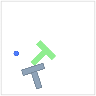

In [7]:
env = PushTEnv()

# use a seed >200 to avoid initial states seen in the training dataset
env.seed(1)

score, imgs = Rollout(
    env,
    policy,
    policy_kwargs = dict(
        num_actions = 1 + action_horizon,  # 1 + 8
        integration_steps_per_action = 6,
    ),
    stats = dataset.stats,
    max_steps = max_rollout_steps,
    obs_horizon = obs_horizon,
    action_horizon = action_horizon,
    device = 'cuda',
)

# print out the maximum target coverage
print('Score: ', score)

# visualize
show_gif(imgs)
